# Stacking Regressor

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
# import lightgbm as lgb
# from lightgbm import LGBMRegressor
# import sklearn
from sklearn import metrics # import f1_score, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot as plt
# import pickle
import joblib

In [2]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train MAE: {:.2f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.2f}%'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('Train R^2: {:.2f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('\n')
    print('Test MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.2f}%'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))
    print('Test R^2: {:.2f}'.format(metrics.r2_score(y_test, y_test_predict)))

def print_test(y_test, y_test_pred):
  y_t = []
  y_t_p = []
  cnt = 0
  for i in range(len(y_test)):
    if cnt < len(y_test):
      y_t.append(y_test[cnt])
      y_t_p.append(y_test_pred[cnt])
      cnt += 1000
    else:
      break
  return(y_t, y_t_p)

In [3]:
X_train_scaled = pd.read_csv('/content/drive/MyDrive/Final_project_of_the_first_year_of_study/google-colab/output/X_train_scaled.zip')
X_test_scaled = pd.read_csv('/content/drive/MyDrive/Final_project_of_the_first_year_of_study/google-colab/output/X_test_scaled.zip')
y_train = pd.read_csv('/content/drive/MyDrive/Final_project_of_the_first_year_of_study/google-colab/output/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Final_project_of_the_first_year_of_study/google-colab/output/y_test.csv')
y_train = y_train['target'].tolist()
y_test = y_test['target'].tolist()
y_train_log = pd.read_csv('/content/drive/MyDrive/Final_project_of_the_first_year_of_study/google-colab/output/y_train_log.csv')
y_train_log = y_train_log['target'].tolist()

In [4]:
# Десериализуем модели из файлов
lr = joblib.load('/content/drive/MyDrive/Final_project_of_the_first_year_of_study/google-colab/fit_models/lr.joblib')
lightgbm = joblib.load('/content/drive/MyDrive/Final_project_of_the_first_year_of_study/google-colab/fit_models/lightgbm.joblib')
gbr = joblib.load('/content/drive/MyDrive/Final_project_of_the_first_year_of_study/google-colab/fit_models/gbr.joblib')
xgboost = joblib.load('/content/drive/MyDrive/Final_project_of_the_first_year_of_study/google-colab/fit_models/xgboost.joblib')
rfr = joblib.load('/content/drive/MyDrive/Final_project_of_the_first_year_of_study/google-colab/fit_models/rfr.joblib')

In [5]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(len(y_train))
print(len(y_test))

(280575, 25)
(70144, 25)
280575
70144


In [6]:
random_state = 42

In [7]:
# Гип. параметры по умолчанию
blend_model = StackingRegressor(estimators=False)
hiperparams = blend_model.get_params()

print("Гиперпараметры по умолчанию:")
for key, value in hiperparams.items():
    print(f"\t{key}: {value}")

Гиперпараметры по умолчанию:
	cv: None
	estimators: False
	final_estimator: None
	n_jobs: None
	passthrough: False
	verbose: 0


In [8]:
# Создадим список кортежей, содержащий имя и объект для каждой модели.
base_models = [('lr', lr), ('lightgbm', lightgbm), ('gbr', gbr), ('xgboost', xgboost), ('rfr', rfr)]

# Создадим blending model.
blend_model = StackingRegressor(estimators=base_models)

# Обучим модель.
blend_model.fit(X_train_scaled, y_train_log)

# # Производим сериализацию и записываем результат в файл формата pkl
# with open('st.pkl', 'wb') as output:
#     pickle.dump(blend_model, output)

# Производим сериализацию и сохраняем результат в файл формата .joblib
joblib.dump(blend_model, '/content/drive/MyDrive/Final_project_of_the_first_year_of_study/google-colab/fit_models/st.joblib')

# Предскажем результат.
y_train_pred_st = np.exp(blend_model.predict(X_train_scaled))
y_test_pred_st = np.exp(blend_model.predict(X_test_scaled))

# Сохраним предсказание в файл.
np.savetxt("/content/drive/MyDrive/Final_project_of_the_first_year_of_study/google-colab/y_test_pred/y_test_pred_st.csv", y_test_pred_st, delimiter=",")

# Покажем метрики.
print_metrics(y_train, y_train_pred_st, y_test, y_test_pred_st)

Train MAE: 53959.46
Train MAPE: 11.11%
Train R^2: 0.87


Test MAE: 64070.38
Test MAPE: 15.64%
Test R^2: 0.84


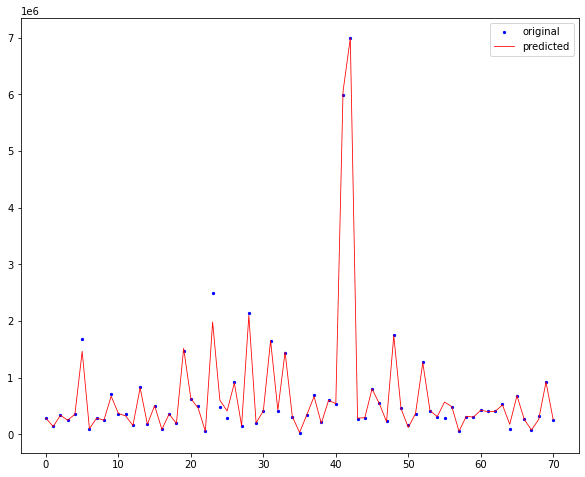

In [9]:
# Возмём каждую 1000-ю строку из выборок, чтобы визуально убедиться в точности предсказаний.
y_t, y_t_p = print_test(y_test, y_test_pred_st)

# Визуализируем предсказания на тестовой выборке.
x_ax = range(len(y_t))
plt.figure(figsize=(10,8))
# Точки тестовой выборки.
plt.scatter(x_ax, y_t, s=5, color="blue", label="original")
# График предсказаний.
plt.plot(x_ax, y_t_p, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [10]:
mae_st = metrics.mean_absolute_error(y_test, y_test_pred_st)
mape_st = metrics.mean_absolute_percentage_error(y_test, y_test_pred_st)*100
r2_st = metrics.r2_score(y_test, y_test_pred_st)

print(round(mae_st, 2))
print(round(mape_st, 2))
print(round(r2_st, 2))

64070.38
15.64
0.84
